In [1]:
! pip install glove_python_binary

You should consider upgrading via the 'c:\users\life\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
from glove import Corpus, Glove
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn import metrics

import joblib
import pandas as pd
import numpy as np
import re
import os
import pickle
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
df_train = pd.read_csv("../../traindata_2015_2018_beforeCovid.csv")
df_test = pd.read_csv("../../testdata_2019_beforeCovid.csv")

In [11]:
# train set
reviews_train = list(df_train["clean_review"])
sentiments_train = list(df_train["sentiment"])
# test set
reviews_test = list(df_test["clean_review"])
sentiments_test = list(df_test["sentiment"])

In [12]:
def token_split(reviews):
    token_li = reviews.split()

    return token_li

In [13]:
review_train_token_li = []
review_test_token_li = []

for i in reviews_train:
    token_review = token_split(i)
    review_train_token_li.append(token_review)

for i in reviews_test:
    token_review = token_split(i)
    review_test_token_li.append(token_review)

In [14]:
corpus = Corpus()
corpus.fit(review_train_token_li, window=20)

In [8]:
glove = Glove(no_components=128, learning_rate=0.01)
%time glove.fit(corpus.matrix, epochs=50, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

glove.save("../glove_w20_epoch50_beforecovid_model")

Performing 50 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Wall time: 21.8 s


In [15]:
glove_model = Glove.load("../../glove_w20_epoch50_beforecovid_model")

In [16]:
type(glove_model.dictionary["data"])

int

In [17]:
word_dict = {}
for word in glove_model.dictionary.keys():
    word_dict[word] = glove_model.word_vectors[glove_model.dictionary[word]]

with open("../glove_word_dic_beforecovid.pkl","wb") as f:
    pickle.dump(word_dict, f)

In [18]:
word_dict["data"]

array([ 0.01435679,  0.01259607, -0.01151377, -0.0131511 ,  0.0108269 ,
        0.00152043,  0.00983161,  0.01279175, -0.01150741, -0.01603906,
       -0.01014677,  0.00494848,  0.01870506, -0.01189149, -0.00449187,
        0.01579875, -0.01285768,  0.00892714, -0.01186818, -0.00651963,
        0.00340269, -0.01276366,  0.01304649, -0.01108224,  0.00756265,
       -0.00919712,  0.0102947 ,  0.00733243, -0.01411882,  0.01501751,
        0.01237668, -0.00932865, -0.00448231, -0.00484224,  0.01487289,
        0.01807652, -0.01154955,  0.00668873,  0.00659067,  0.00877854,
       -0.00629583, -0.01180506,  0.00184818,  0.01183708, -0.01227313,
       -0.00919623,  0.01106165,  0.00923073, -0.0104034 ,  0.01588238,
        0.01744273, -0.01289231,  0.00404113,  0.01025682,  0.01522458,
        0.01579261, -0.00718805, -0.01451678,  0.01005   ,  0.01057466,
        0.01500026,  0.01103929, -0.01423668, -0.00858739,  0.01387821,
       -0.01154479,  0.01342974, -0.00221878,  0.01529022,  0.01

In [19]:
total_word_dict = {} # 교집합
count = 0

for review_token in review_test_token_li: 
    for word in review_token:
        if word in word_dict.keys():
            total_word_dict[word] = word_dict[word]

        else:
            word_dict[word] = np.zeros((128))
            count += 1

print(count)

2039


In [20]:
def glove_sentence_embedding(token_li, embedding_dim=128):
    token_len = len(token_li)
    sentence_matrix = np.zeros((token_len, embedding_dim))

    for i, token in enumerate(token_li):
        sentence_vector = np.array([word_dict[j] for j in token if j in word_dict])
        sentence_vector = np.mean(sentence_vector, axis=0)
        sentence_matrix[i] = sentence_vector

    return sentence_matrix

In [21]:
print(len(review_train_token_li))
print(len(review_test_token_li))

31312
14208


In [22]:
train_sentence_glove = glove_sentence_embedding(review_train_token_li)
test_sentence_glove = glove_sentence_embedding(review_test_token_li)

print(len(train_sentence_glove))
print(len(test_sentence_glove))

31312
14208


In [23]:
X_train = train_sentence_glove
y_train = np.array(sentiments_train)

X_test = test_sentence_glove
y_test = np.array(sentiments_test)

In [24]:
nb = BernoulliNB()
nb.fit(X_train, y_train)

nb_pred = nb.predict(X_test)

In [25]:
print("Accuracy: %f" % accuracy_score(y_test, nb_pred))

Accuracy: 0.803702


Text(0.5, 257.44, 'Predicted label')

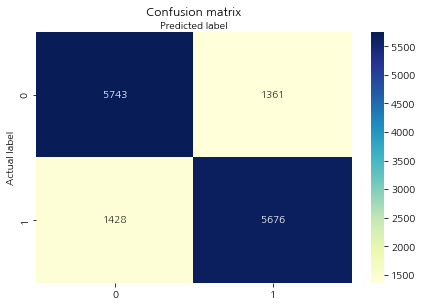

In [26]:
cnf_matrix = metrics.confusion_matrix(y_test, nb_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [27]:
print("Accuracy:",metrics.accuracy_score(y_test, nb_pred))
print("Precision:",metrics.precision_score(y_test, nb_pred))
print("Recall:",metrics.recall_score(y_test, nb_pred))
print("F1-score:",metrics.f1_score(y_test, nb_pred))

Accuracy: 0.8037021396396397
Precision: 0.8065937189143101
Recall: 0.7989864864864865
F1-score: 0.8027720811823775


In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, nb_pred, target_names=['class low', 'class high']))

              precision    recall  f1-score   support

   class low       0.80      0.81      0.80      7104
  class high       0.81      0.80      0.80      7104

    accuracy                           0.80     14208
   macro avg       0.80      0.80      0.80     14208
weighted avg       0.80      0.80      0.80     14208



In [29]:
report = classification_report(y_test, nb_pred, target_names=['class low', 'class high'], output_dict=True)
df = pd.DataFrame(report).transpose()

df

,precision,recall,f1-score,support
class low,0.800865,0.808418,0.804623,7104.000000
class high,0.806594,0.798986,0.802772,7104.000000
accuracy,0.803702,0.803702,0.803702,0.803702
macro avg,0.803729,0.803702,0.803698,14208.000000
weighted avg,0.803729,0.803702,0.803698,14208.000000


In [30]:
joblib.dump(nb,'nb_GloVe_beforeCoivd_0.803702')

['nb_GloVe_beforeCoivd_0.803702']